# San Francisco Rental Prices
_______________________________________________________________________________________________________________________________________________________________

##### In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [2]:
# initial imports
import os
import pandas as pd
import matplotlib.pyplot as plt

import plotly.express as px
from pathlib import Path
from dotenv import load_dotenv

# Initialize the Panel Extensions (for Plotly)
import panel as pn
pn.extension('plotly')
import hvplot.pandas

In [3]:
# Read the Mapbox API key

load_dotenv()

mapbox_token = os.getenv("MAPBOX_API_KEY")

px.set_mapbox_access_token(mapbox_token)

## Import Data
_____________________________________________________________________________________________________________________________________________________________

In [4]:
# Import the CSVs to Pandas DataFrames
file_path = Path("sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

file_path = Path("neighborhoods_coordinates.csv")
df_neighborhood_locations = pd.read_csv(file_path)
sfo_data.head(10)

,neighborhood,sale_price_sqr_foot,housing_units,gross_rent
year,,,,
2010,Alamo Square,291.182945,372560,1239
2010,Anza Vista,267.932583,372560,1239
2010,Bayview,170.098665,372560,1239
2010,Buena Vista Park,347.394919,372560,1239
2010,Central Richmond,319.027623,372560,1239
2010,Central Sunset,418.172493,372560,1239
2010,Corona Heights,369.359338,372560,1239
2010,Cow Hollow,569.379968,372560,1239
2010,Croker Amazon,165.645730,372560,1239


##  Panel Visualizations
____________________________________________________________________________________________________________________________________________________________

##### In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 
##### These functions will convert the plot object to a Panel pane.
##### Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.
##### Return a Panel pane object from each function that can be used to build the dashboard.
##### Note: Remove any .show() lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

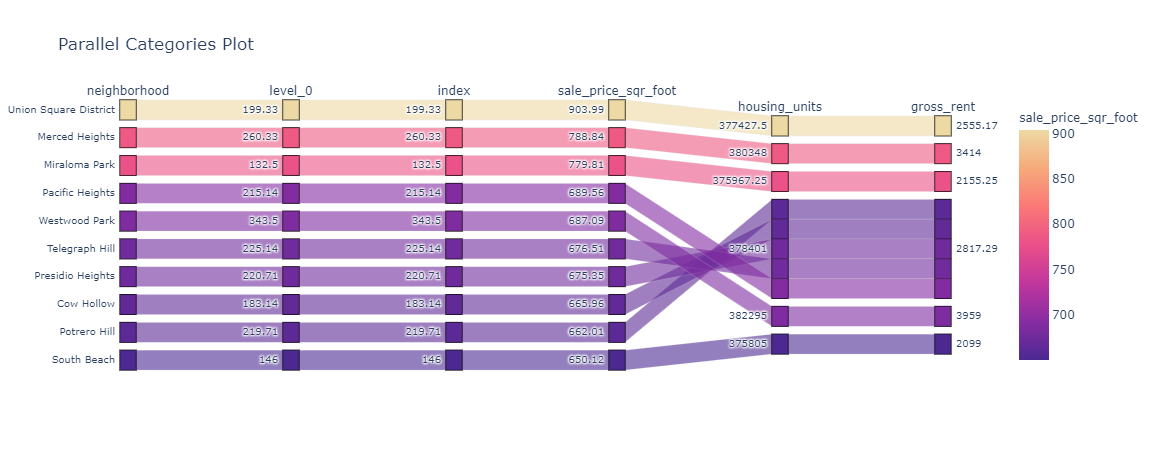

In [15]:

# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    housing_unit_by_year = sfo_data["housing_units"].groupby([sfo_data.index]).mean()
       
    fig_housing_units = plt.figure()
    plot_housing_units = housing_unit_by_year.plot.bar()
    plot_housing_units.set_xlabel("Year", fontsize=12)
    plot_housing_units.set_ylabel("Housing Units", fontsize=12)
    plot_housing_units.set_title(
        "Housing Units in San Francisco from 2010 to 2016", fontsize=14, fontweight="bold"
    )
    # Optional Challenge: Use the min, max, and std to scale the y limits of the chart
    housing_units_std = housing_unit_by_year.std()
    housing_units_min = min(housing_unit_by_year)
    housing_units_max = max(housing_unit_by_year)
    
    plot_housing_units.set_ylim(
        housing_units_min - housing_units_std, housing_units_max + housing_units_std
    )
    
    plt.close(fig_housing_units)
    return pn.pane.Matplotlib(fig_housing_units, tight=True)

 
def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    return housing_unit_by_year['gross_rent'].mean().hvplot(
        label='Average Gross Rent in San Francisco',
        xlabel='Year', ylabel='Gross Rent',
        xlim=(housing_unit_by_year.first().index.min(), housing_unit_by_year.first().index.max())
    )


def average_sales_price():
    """Average Sales Price Per Year."""
    
    return housing_unit_by_year['sale_price_sqr_foot'].mean().hvplot(
        label='Average Sales Price in San Francisco',
        xlabel='Year', ylabel='Avg. Sale Price',
        xlim=(housing_unit_by_year.first().index.min(), housing_unit_by_year.first().index.max())
    )


neighborhood_df = sfo_data.groupby(['year','neighborhood']).mean().reset_index()

def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    
    return neighborhood_df.hvplot(
        label='Average Price per Square feet by year',
        x='year',
        y='sale_price_sqr_foot',
        xlabel='Year',
        ylabel='Avg. Sales Price per Square Foot', 
        #shared_axes=False,
        #ylim=(top_expensive_neighborhood['sale_price_sqr_foot'].min()-100,top_expensive_neighborhood['sale_price_sqr_foot'].max()+100),
        groupby='neighborhood'
    )

avg_neighborhood_values = neighborhood_df.drop(columns=['year']).groupby('neighborhood').mean().round(2)
highest_neighborhood = avg_neighborhood_values.sort_values("sale_price_sqr_foot", ascending = False).head(10)

def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    
    return highest_neighborhood['sale_price_sqr_foot'].hvplot.bar(
        labels='Top 10 Expensive Neighborhoods in SFO',
        xlabel='Neighborhood',
        shared_axes=False,
        ylabel='Avg. Sales Price per Square Foot', 
        rot=45
    )


def parallel_coordinates():
    """Parallel Coordinates Plot."""
    
    return px.parallel_coordinates(
        highest_neighborhood, 
        title='Parallel Coordinates Plot',
        color='sale_price_sqr_foot'
    )


def parallel_categories():
    """Parallel Categories Plot."""
    
    return px.parallel_categories(
        highest_neighborhood.reset_index(), 
        color='sale_price_sqr_foot',
        title='Parallel Categories Plot',
        color_continuous_scale=px.colors.sequential.Agsunset
    )


def neighborhood_map():
    """Neighborhood Map"""
    
    new_avg_values_neighborhood=avg_neighborhood_values.reset_index().rename(columns = {'neighborhood':'Neighborhood'})
    neighborhood_location=pd.merge(df_neighborhood_locations,new_avg_values_neighborhood, on='Neighborhood')
    
    return px.scatter_mapbox(neighborhood_location,
                             lat="Lat",
                             lon="Lon",
                             size='sale_price_sqr_foot',
                             color='gross_rent',
                             hover_name='Neighborhood',
                             zoom=11,
                             color_continuous_scale=px.colors.sequential.Jet
                            )

parallel_categories()

## Panel Dashboard
##### In this section, you will combine all of the plots into a single dashboard view using Panel.
##### Be creative with your dashboard design!

In [ ]:
location_column = pn.Column(' Visual analysis of the real estate investment opportunities in San Fransco with interactive map with the average prices per neighborhood',
                           neighborhood_map())

yearly_market_analysis = pn.Row(housing_units_per_year(), average_gross_rent(), average_sales_price())

neighborhood_analysis = pn.Column(average_price_by_neighborhood(), top_most_expensive_neighborhoods())

parallel_plot_analysis = pn.Column(parallel_coordinates(), parallel_categories())


panel_content = pn.Tabs(
    ('Welcome', location_column),
    ('Yearly Market Analysis', yearly_market_analysis),
    ('Neighborhood Analysis', neighborhood_analysis),
    ('Parallel Plot Analysis', parallel_plot_analysis)
)

#panel = pn.Column(f'# Real Estate Analysis of San Francisco from {sfo_data.index.min()} to {sfo_data.index.max()}<br/>',
#                  panel_content)
                 

##  Serve the Panel Dashboard

In [ ]:
# Serve the Panel Dashboard
panel.servable()